In [7]:
%matplotlib inline
import math
import random
import copy
import collections
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.patches import Ellipse

# Particle Class Object
class Particle:
    def __init__(self, p, w):  # 姿勢も指定できるようにしましょう
        self.pose = np.array(p)
        self.weight = w

    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)


# it's function to update state and pose
def update_state(u, state, error=True):
    x, y, theta = state
    l, omega = u
    if error:
        l = random.gauss(l, l / 10)
        omega = random.gauss(omega, omega / 10)
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)
    else:
        dir_error = 0

    x = x + np.cos(theta + dir_error) * l
    y = y + np.sin(theta + dir_error) * l
    theta = theta + omega

    return [x, y, theta]


# generate (init) particles. if it has no args, init particles use random
def generate_particles(init_weight=None, sample=None):
    if sample is None:
        sample = 1000
    if init_weight is None:
        weight_list = [1.0 / sample for i in range(sample)]
    else:
        weight_list = init_weight
    initial_particles = collections.deque()
    for i in range(sample):
        x = random.uniform(-1, 1)
        y = random.uniform(-0.5, 1.5)
        theta = random.uniform(0, 360)
        initial_particles.append(Particle([x, y, theta], weight_list[i] * 1.0))
    return initial_particles


# make accumulation of weights
def make_accum(particles):
    accum = collections.deque()
    sm = 0.0
    for p in particles:
        accum.append(p.weight + sm)
        sm = sm + p.weight
    return accum


# update Particle. delete far particle, and increase particle that has high likelihood
def update_particles(particles):
    accum = make_accum(particles)
    re_N = 1.0 / len(particles)
    max_weight = 0
    pointer = random.uniform(0.0, re_N)
    new_particles = collections.deque()
    while pointer < 1.0 and len(particles) > 0:
        if accum[0] >= pointer:
            new_particles.append(
                Particle(copy.deepcopy(particles[0].pose), re_N))
            pointer += re_N
            if max_weight < particles[0].weight:
                max_weight = particles[0].weight
        else:
            accum.popleft()
            particles.popleft()
    # particle が 半分以下の場合と少ないパーティクルに重みが集中しすぎている場合信用ならない
    # if max_weight > 0.9:
    #     new_particles = generate_particles()
    if len(new_particles) < (1 / re_N / 2):
        new_particles = generate_particles()
    return new_particles

def relative_landmark_pos(pose, landmark):
    x, y, theta = pose
    lx, ly = landmark
    distance = math.sqrt((x - lx)**2 + (y - ly)**2)
    direction = math.atan2(ly - y, lx - x) - theta
    return (distance, direction, lx, ly)  # 実際の位置も一緒に返す


def observation(pose, landmark):
    actual_distance, actual_direction, lx, ly = relative_landmark_pos(
        pose, landmark)
    if math.cos(actual_direction) < 0.0:
        return None
    measured_distance = random.gauss(actual_distance, actual_distance / 10)
    measured_direction = random.gauss(actual_direction, 5 * math.pi / 180)
    return [measured_distance, measured_direction, lx, ly]
    # return [actual_distance, actual_direction, lx, ly]


def observations(pose, landmarks):
    return list(filter(lambda x: x != None, [observation(pose, i) for i in landmarks]))


def calc_likelihood(pose, measurement):
    x, y, theta = pose
    # robot が確認した ランドマークの距離と向き
    distance, direction, lx, ly = measurement
    # particle の位置から推測されるはずのランドマークの距離と向き
    rel_dist, rel_direct, tmpx, tmpy = relative_landmark_pos(pose, [lx, ly])

    return norm.pdf(x = distance - rel_dist, loc = 0.0, scale = rel_dist / 10.0)  \
           * norm.pdf(x = direction - rel_direct, loc = 0.0, scale = 5.0/180.0 * math.pi)


def change_weights(particles, measurement):
    for p in particles:
        p.weight *= calc_likelihood(p.pose, measurement)
    ws = [p.weight for p in particles]
    s = sum(ws)
    for p in particles: p.weight = p.weight / s

def calc_measurements(state, landmarks, measurements_list):
    ms = observations(state, landmarks)
    measurements_list.append(ms)
    return ms

def draw(pose, particles, i):
    fig = plt.figure(i, figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0, 1.0)
    sp.set_ylim(-0.5, 1.5)

    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2]) * e.weight for e in particles]
    vys = [math.sin(e.pose[2]) * e.weight for e in particles]
    plt.quiver(xs, ys, vxs, vys, color="blue", label="particles")
    plt.quiver([pose[0]], [pose[1]], [math.cos(pose[2])], [
               math.sin(pose[2])], color="red", label="actual robot motion")


def draw_landmarks(landmarks):
    xs = [e[0] for e in landmarks]
    ys = [e[1] for e in landmarks]
    plt.scatter(xs, ys, s=300, marker="*", label="landmarks", color="orange")



def draw_observation(pose, measurement):
    x, y, theta = pose
    mdistance, mdirection, lx, ly = measurement
    lx = x + mdistance * math.cos(theta + mdirection)
    ly = y + mdistance * math.sin(theta + mdirection)
    plt.plot([x, lx], [y, ly], color='pink')


def draw_observations(pose, measurements):
    for i in measurements:
        draw_observation(pose, i)


def draw_elements(path, particles, landmarks, measurements_list, i):
    draw(path[-1], particles, i)
    draw_landmarks(landmarks)
    draw_observations(path[-1], measurements_list[-1])



# メインの大きいところ
def simurate_robot(particles, state, u, landmarks):
    measurements_list = [observations(state, landmarks)]
    particle_path = [copy.deepcopy(particles)]
    path = [copy.deepcopy(state)]
    for i in range(LOOP_RANGE):
        state = update_state(u, state)
        ms = calc_measurements(state, landmarks, measurements_list)
        for p in particles: p.pose = update_state(u, p.pose)
        for m in ms: change_weights(particles, m)
        particle_path.append(copy.deepcopy(particles))
        path.append(state)
        if i % MOD_NUM == 0:
            draw_elements(path, particles, landmarks, measurements_list, i)
        particles = update_particles(particles)




/Users/aoki/.pyenv/versions/3.6.1/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in double_scalars


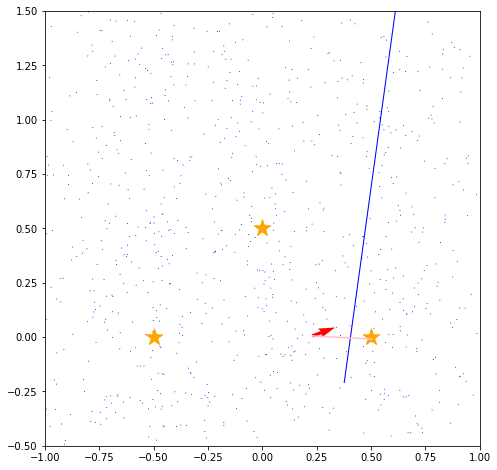

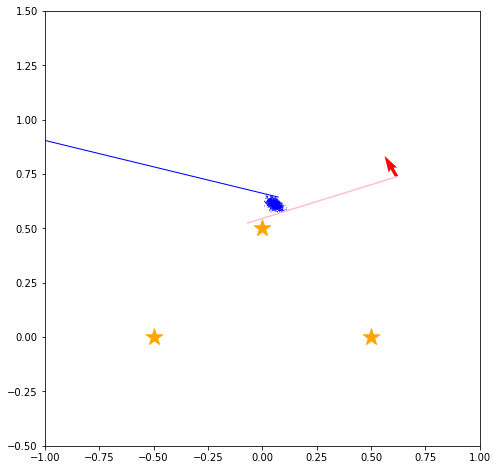

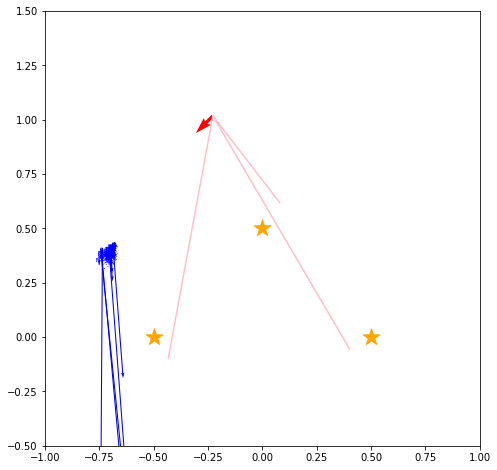

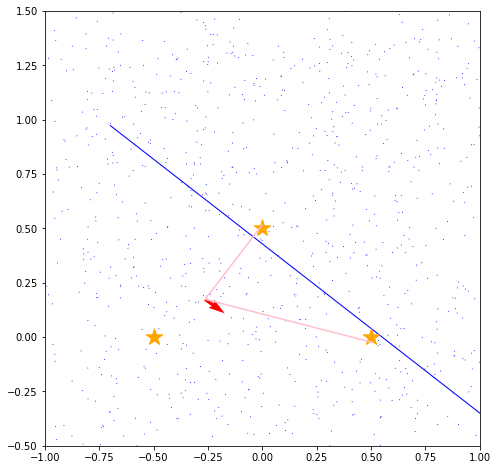

/Users/aoki/.pyenv/versions/3.6.1/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/quiver.py:646: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/aoki/.pyenv/versions/3.6.1/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aoki/.pyenv/versions/3.6.1/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/quiver.py:720: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/Users/aoki/.pyenv/versions/3.6.1/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/quiver.py:734: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


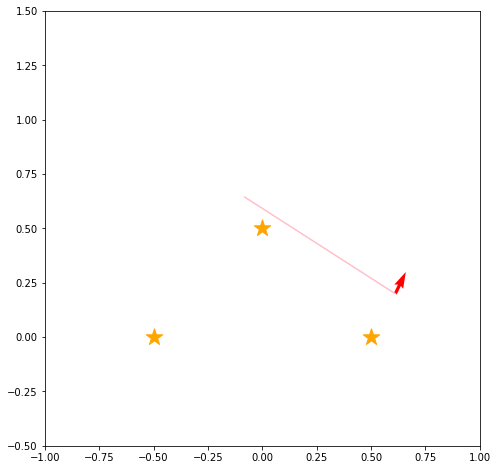

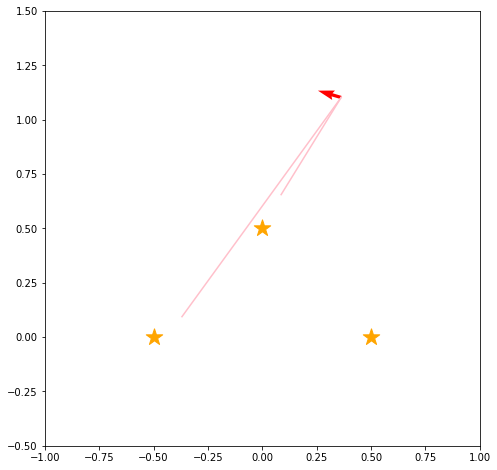

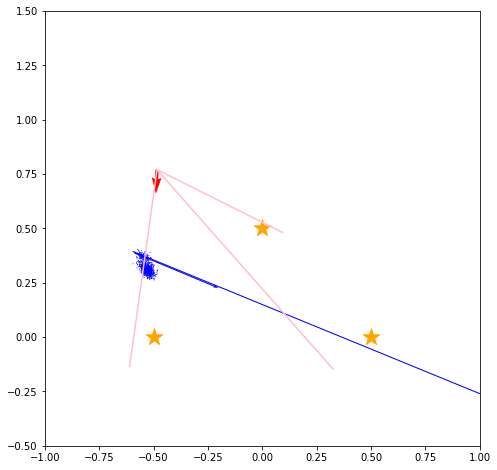

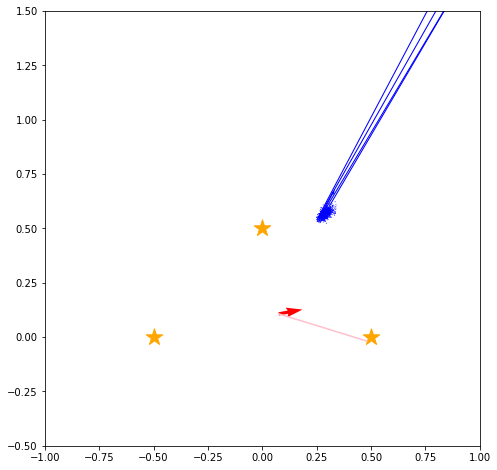

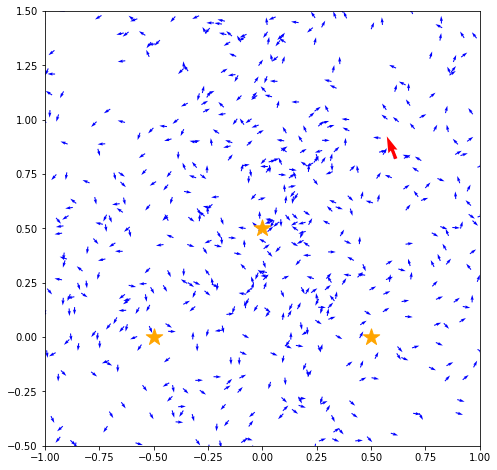

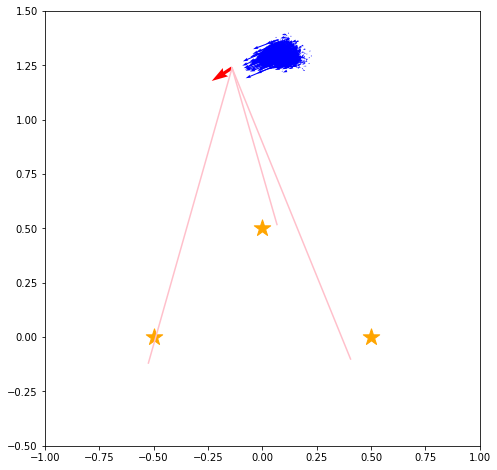

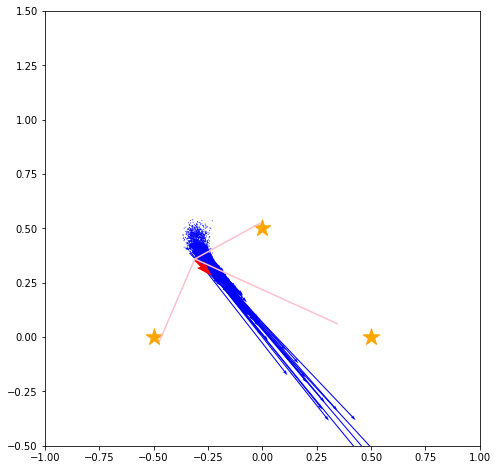

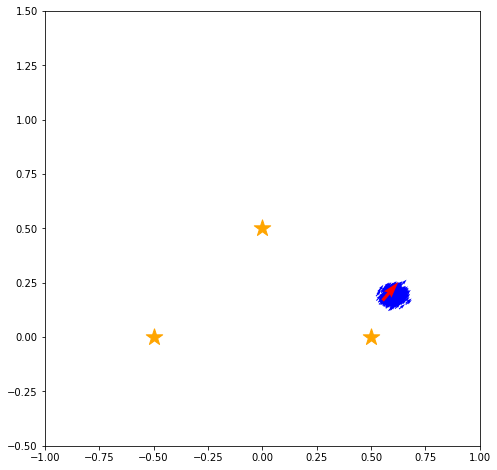

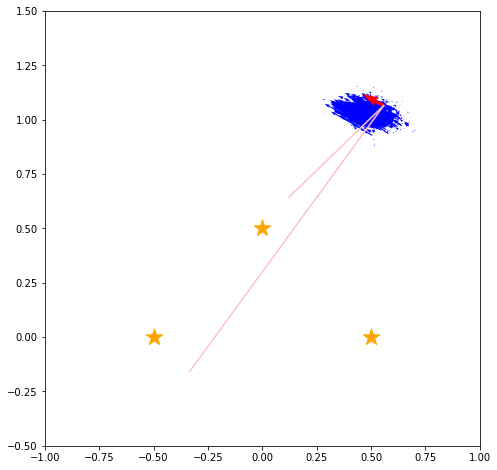

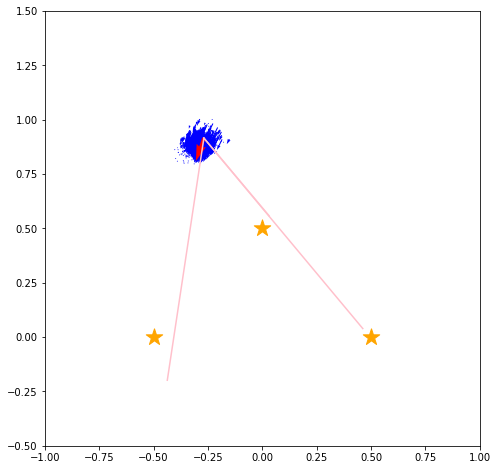

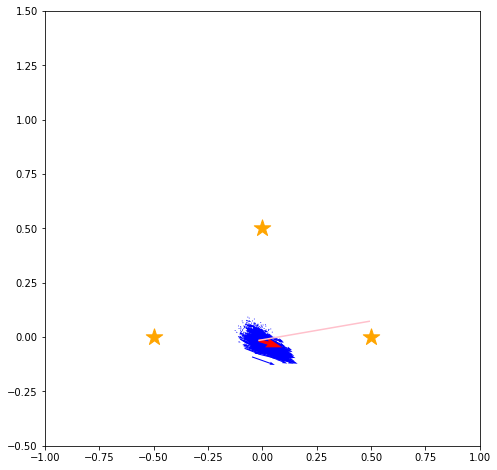

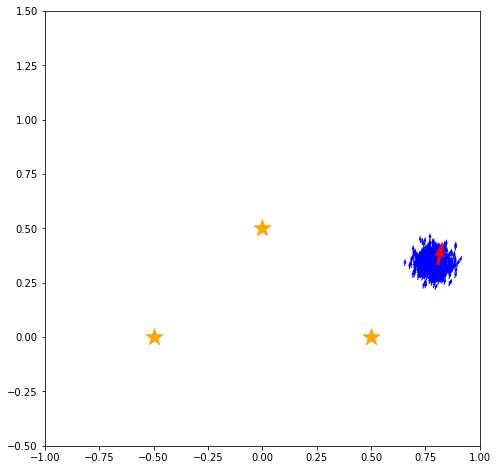

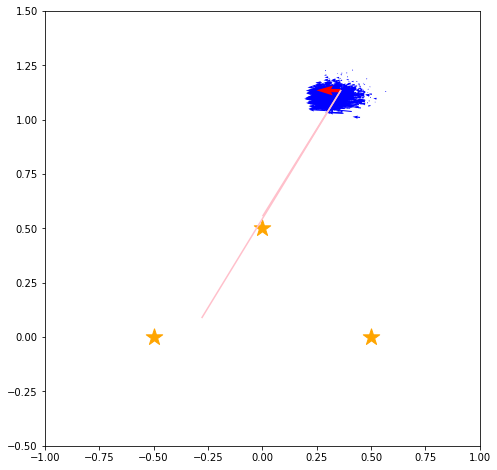

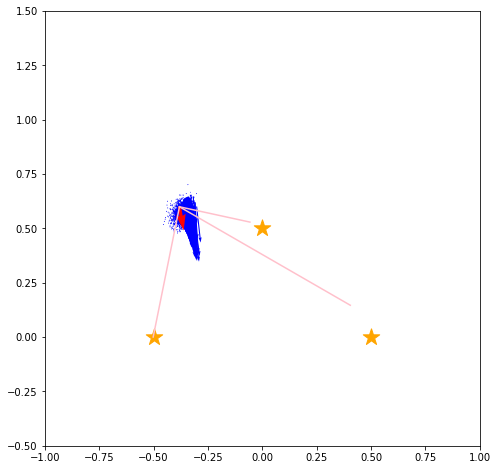

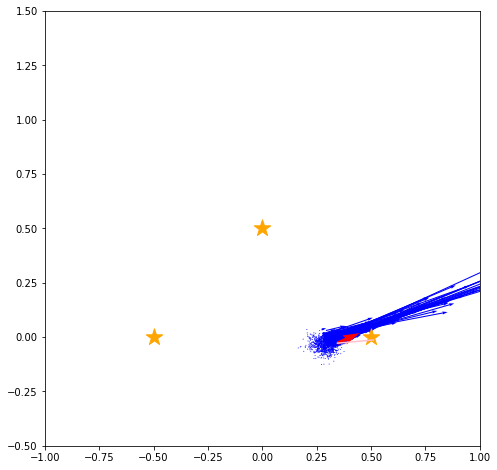

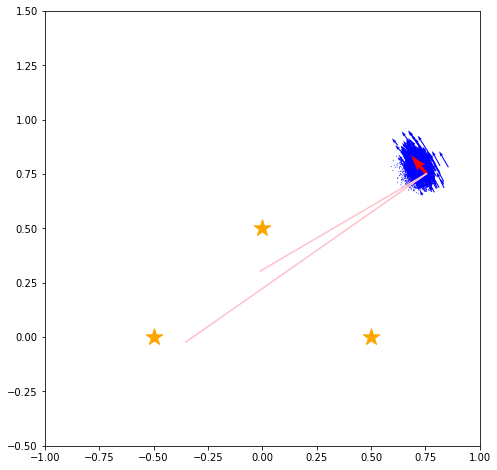

In [8]:

# User define
INITIAL_STATE = [0.0, 0.0, 0.0]
LOOP_RANGE = 100
MOD_NUM = LOOP_RANGE / 20
U = np.array([0.2, math.pi / 180 * 20])
RANDMARKS = [np.array([-0.5, 0.0]), np.array([0.5, 0.0]), np.array([0.0, 0.5])]



actual_randmarks = RANDMARKS
particles = generate_particles()
state = INITIAL_STATE
u = U
simurate_robot(particles, state, u, actual_randmarks)